# <center> FITS Comparison

In [90]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
import math
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params
import pyabc
import os
import scipy.stats as st
import pandas as pd
import subprocess
import time

In [91]:
def wf_with_selection_and_mutation(wt_freq, population_size, fitness, mutation_rate, sequence_sample_size):
    # math from https://academic.oup.com/sysbio/article/66/1/e30/2670014#syw056M2 
    wt_freq = wt_freq*(1 - mutation_rate) + (1 - wt_freq)*mutation_rate                  # mutation
    wt_freq = (wt_freq * fitness) / ( (1-wt_freq) + (wt_freq * fitness))                 # selection
    wt_freq = np.random.binomial(population_size, wt_freq) / population_size             # bottleneck
    return wt_freq
    
    
def wt_generations(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                   color=None, label=None, plot=True):
    freqs = []
    for i in range(generations_number):
        wt_freq = wf_with_selection_and_mutation(wt_freq=wt_freq, population_size=population_size, 
                                                 fitness=fitness, mutation_rate=mutation_rate, 
                                                 sequence_sample_size=sequence_sample_size)
        freqs.append(wt_freq)
    freqs = np.random.binomial(sequence_sample_size, freqs) / sequence_sample_size   # sequence sampling
    if plot:
        plt.plot(range(generations_number), freqs, color=color, label=label, alpha=0.1)
    return np.array(freqs)


def simulate_50(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                 color=None, label=None, plot=True):
    if plot:
        plt.xlabel('Generation')
        plt.ylabel('Frequency')
    data = []
    for i in range(50):
        datum = wt_generations(generations_number=generations_number, wt_freq=wt_freq, plot=plot,
                               population_size=population_size, fitness=fitness, mutation_rate=mutation_rate, 
                               color=color,  sequence_sample_size=sequence_sample_size, 
                               label=label if i==0 else None)
        data.append(datum)
    if label:
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    return pd.DataFrame(data)

In [92]:
def pyFITS(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = 10**prior_dist.rvs()['x']
        sym = wt_generations(mutation_rate=prior, generations_number=params['gen'], wt_freq=params['freq0'], 
                             population_size=params['pop'], fitness=params['fit'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = (abs(sym-data) + abs((1-sym)-(1-data))).sum()  # correction to align with FITS weirdness
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = np.log10(df['post'])
    return df

def pyFITS_fitness(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = prior_dist.rvs()['x']
        sym = wt_generations(fitness=prior, mutation_rate=params['mut'], generations_number=params['gen'], 
                             wt_freq=params['freq0'], population_size=params['pop'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = (abs(sym-data) + abs((1-sym)-(1-data))).sum()  # correction to align with FITS weirdness
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = df['post']
    return df

In [93]:
def run_pyFITS(prior_dist, data, num_sim, top_fraction, model_params, fitness=False):
    start = time.time()
    if fitness:
        post = pyFITS_fitness(prior_dist, data, num_sim, model_params, top_fraction)
    else:
        post = pyFITS(prior_dist, data, num_sim, model_params, top_fraction)
    print("pyFITS run time ", round(time.time()-start,2))
    print(f"pyFITS Created posterior from {len(post)} results")
    print(f"pyFITS max epsilon: {post.distance.max()}")
    return post

In [94]:
def smc_model(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameters['x']
    fitness = 1
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

def smc_model_fit01(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameters['x']
    fitness = 1.01
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)} 


def smc_model_fitness(parameters):
    pop_size = 100000000
    gen_num = 10
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 0.0007
    fitness = parameters['x']
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

In [95]:
def plot_smc(smc_out):
    fig, ax = plt.subplots()
    for t in range(smc_out.max_t+1):
        df, w = smc_out.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df, w,
            x="x", ax=ax,
            label="PDF t={}".format(t))
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()


In [96]:
def last_freq_L1(simulation, data):
    return abs(data['a'] - simulation['a']).sum()

def run_smc(priors, data, epsilon, fitness=False):
    start = time.time()
    if fitness == 1.01:
        model = smc_model_fit01
    elif fitness == 1:
        model = smc_model
    elif fitness == 'infer':
        model = smc_model_fitness        
    abc = pyabc.ABCSMC(
            model, priors,
            last_freq_L1, population_size=1000, sampler=pyabc.sampler.SingleCoreSampler())
    db_path = ("sqlite:///test.db")
    smc_post = abc.new(db_path, {'a': data})
    smc_post = abc.run(minimum_epsilon=epsilon, max_nr_populations=10)
    print("SMC run time: ", round(time.time()-start,2))
    print("Total number of SMC simulations: ", smc_post.total_nr_simulations)
    plot_smc(smc_post)
    return smc_post

In [105]:
def plot_kdes(smc_output, pyFITS_output, FITS_output, real_value, fitness=False):
    fig, ax = plt.subplots()
    df, w = smc_output.get_distribution(m=0)
    pyabc.visualization.plot_kde_1d(
        df, w, 
        x="x", ax=ax,
        label="ABCSMC")
    if not fitness:
        real_value = math.log10(real_value)
    ax.axvline(real_value, color="k", linestyle="dashed")
    pyabc.visualization.plot_kde_1d(
        pyFITS_output, np.ones(len(pyFITS_output))/len(pyFITS_output), label='pyFITS', x='log_post', ax=ax)
    pyabc.visualization.plot_kde_1d(
        FITS_output, np.ones(len(FITS_output))/len(FITS_output), label='FITS', x='log', ax=ax)
    plt.title('Posterior')
    plt.legend()
    if fitness:
        plt.xlabel('fitness')
    else:
        plt.xlabel('log mutation rate')
    return fig, ax

In [106]:
def create_fits_input_data(data):
    outfile = 'fits_input_data.tsv'
    fits = dict()
    fits['mut'] = pd.DataFrame(data={'freq': data})
    fits['wt'] = pd.DataFrame(data={'freq': 1-data})
    fits['mut']['allele'] = 1
    fits['wt']['allele'] = 0
    fits_input = pd.concat(fits.values()).reset_index().rename(columns={'index': 'gen'})
    fits_input=fits_input[['gen','allele','freq']]
    fits_input.to_csv(outfile, index=False, sep='\t')
    return outfile
    
def run_FITS(data, params_file=None, fitness=False):
    """FITS params need to be edited manually"""
    input_data_file = create_fits_input_data(data)
    if fitness:
        run_type = 'fitness'
        if not params_file:
            params_file = "../FITS/params_f01_mr734.txt"
        
    else:
        run_type = 'mutation'
        if not params_file:
            params_file = "../FITS/parameters.txt"
    cmd = f"./../FITS/fits1.3.3 -{run_type} {params_file} {input_data_file} fits_post.tsv fits_sum.txt"
    start = time.time()
    subprocess.run(cmd.split())
    print("FITS run time: ", round(time.time()-start,2))
    fits_post = pd.read_table('fits_post.tsv')
    if fitness:
        fits_post['log'] = fits_post['allele1']
    else:
        fits_post['log'] = np.log10(fits_post['allele0_1'])
    return fits_post

In [107]:
def compare_pyFITS(mutation_rate, prior_edges=[-7,-2], num_sim=100000, top_fraction=0.01, 
                   params_file=None, fitness=1):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': fitness}
    print("Creating dataset...")
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=mutation_rate,
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                             plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", prior_edges[0], prior_edges[1]-prior_edges[0]))
    print("running pyFits...")
    pyfits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params)
    print("Running FITS...")
    fits_out = run_FITS(data, params_file)
    print("FITS max distance: ", fits_out['distance'].max())
    print("pyFITS max distance: ", pyfits_out['distance'].max())
    epsilon = pyfits_out['distance'].max()
    print("Running SMC with epsilon: ", epsilon)
    smc_out = run_smc(prior_dist, data, epsilon, fitness)
    return plot_kdes(smc_out, pyfits_out, fits_out, mutation_rate)
    

In [108]:
def compare_fitness_inference(fitness,  num_sim=100000, top_fraction=0.01,  params_file=None, 
                              mutation_rate=0.0007):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': fitness, 'mut': mutation_rate}
    print("Creating dataset...")
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=params['mut'],
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                       plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", 0, 2))
    print("running pyFits...")
    pyfits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params, fitness=True)
    print("Running FITS...")
    fits_out = run_FITS(data, params_file, fitness=True)
    print("FITS max distance: ", fits_out['distance'].max())
    print("pyFITS max distance: ", pyfits_out['distance'].max())
    epsilon = pyfits_out['distance'].max()
    print("Running SMC with epsilon: ", epsilon)
    smc_out = run_smc(prior_dist, data, epsilon, fitness='infer')
    return plot_kdes(smc_out, pyfits_out, fits_out, fitness, fitness=True)

# Comparing fitness inference

Creating dataset...
running pyFits...
pyFITS run time  89.21
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0042899999999999544
Running FITS...


INFO:History:Start <ABCSMC(id=180, start_time=2021-02-11 09:13:58.880908, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  3.69
FITS max distance:  0.00370438
pyFITS max distance:  0.0042899999999999544
Running SMC with epsilon:  0.0042899999999999544


INFO:Epsilon:initial epsilon is 0.038079800000000004
INFO:ABC:t: 0, eps: 0.038079800000000004.
INFO:ABC:Acceptance rate: 1000 / 2110 = 4.7393e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.02899.
INFO:ABC:Acceptance rate: 1000 / 2063 = 4.8473e-01, ESS=9.9658e+02.
INFO:ABC:t: 2, eps: 0.017944159027082646.
INFO:ABC:Acceptance rate: 1000 / 1993 = 5.0176e-01, ESS=9.9210e+02.
INFO:ABC:t: 3, eps: 0.009709800000000001.
INFO:ABC:Acceptance rate: 1000 / 2072 = 4.8263e-01, ESS=9.9951e+02.
INFO:ABC:t: 4, eps: 0.005126649848607611.
INFO:ABC:Acceptance rate: 1000 / 2039 = 4.9044e-01, ESS=9.9879e+02.
INFO:ABC:t: 5, eps: 0.0028594442105770363.
INFO:ABC:Acceptance rate: 1000 / 1923 = 5.2002e-01, ESS=9.9663e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=180, start_time=2021-02-11 09:13:58.880908, end_time=2021-02-11 09:14:25.905293)>


SMC run time:  27.05
Total number of SMC simulations:  13200


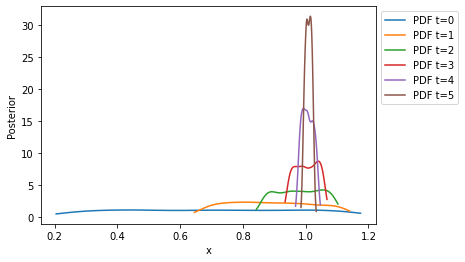

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>)

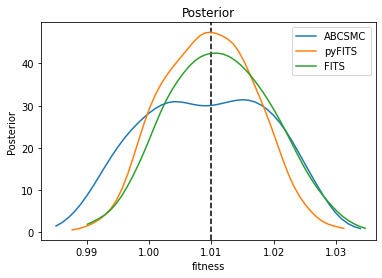

In [101]:
compare_fitness_inference(1.01)

Creating dataset...
running pyFits...
pyFITS run time  74.68
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0045683999999997435
Running FITS...


INFO:History:Start <ABCSMC(id=170, start_time=2021-02-11 08:37:29.218364, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  2.85
FITS max distance:  0.00393722
pyFITS max distance:  0.0045683999999997435
Running SMC with epsilon:  0.0045683999999997435


INFO:Epsilon:initial epsilon is 0.04135459999999998
INFO:ABC:t: 0, eps: 0.04135459999999998.
INFO:ABC:Acceptance rate: 1000 / 2020 = 4.9505e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.032604599999999984.
INFO:ABC:Acceptance rate: 1000 / 2045 = 4.8900e-01, ESS=9.9812e+02.
INFO:ABC:t: 2, eps: 0.020591059222599406.
INFO:ABC:Acceptance rate: 1000 / 2062 = 4.8497e-01, ESS=9.9957e+02.
INFO:ABC:t: 3, eps: 0.01149605998462627.
INFO:ABC:Acceptance rate: 1000 / 2000 = 5.0000e-01, ESS=9.9870e+02.
INFO:ABC:t: 4, eps: 0.006227439968941198.
INFO:ABC:Acceptance rate: 1000 / 2058 = 4.8591e-01, ESS=9.9941e+02.
INFO:ABC:t: 5, eps: 0.003348369756231336.
INFO:ABC:Acceptance rate: 1000 / 2081 = 4.8054e-01, ESS=9.9405e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=170, start_time=2021-02-11 08:37:29.218364, end_time=2021-02-11 08:37:51.268443)>


SMC run time:  22.07
Total number of SMC simulations:  13266


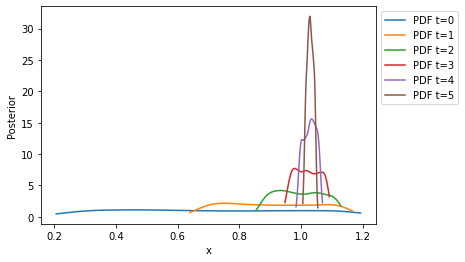

((<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>),
      position  distance  allele0  allele1      log
 0         NaN  0.001178        1  1.02863  1.02863
 1         NaN  0.001206        1  1.03739  1.03739
 2         NaN  0.001273        1  1.03548  1.03548
 3         NaN  0.001373        1  1.03001  1.03001
 4         NaN  0.001379        1  1.04300  1.04300
 ..        ...       ...      ...      ...      ...
 995       NaN  0.003930        1  1.03630  1.03630
 996       NaN  0.003933        1  1.05135  1.05135
 997       NaN  0.003934        1  1.02482  1.02482
 998       NaN  0.003935        1  1.04833  1.04833
 999       NaN  0.003937        1  1.04595  1.04595
 
 [1000 rows x 5 columns],
        distance      post  log_post
 38145  0.001277  1.031506  1.031506
 6114   0.001328  1.034740  1.034740
 57198  0.001332  1.030323  1.030323
 83400  0.001492  1.028452  1.028452
 2071   0.001533  1.025368  1.025368
 ...

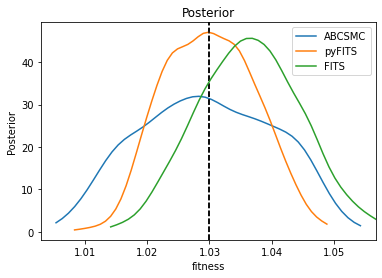

In [58]:
compare_fitness_inference(1.03)

Creating dataset...
running pyFits...
pyFITS run time  66.82
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.005841599999999943
Running FITS...


INFO:History:Start <ABCSMC(id=168, start_time=2021-02-11 08:28:48.337849, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  3.46
FITS max distance:  0.00543931
pyFITS max distance:  0.005841599999999943
Running SMC with epsilon:  0.005841599999999943


INFO:Epsilon:initial epsilon is 0.0552288
INFO:ABC:t: 0, eps: 0.0552288.
INFO:ABC:Acceptance rate: 1000 / 2106 = 4.7483e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0427438.
INFO:ABC:Acceptance rate: 1000 / 2122 = 4.7125e-01, ESS=9.9242e+02.
INFO:ABC:t: 2, eps: 0.027009987498858603.
INFO:ABC:Acceptance rate: 1000 / 2015 = 4.9628e-01, ESS=9.9895e+02.
INFO:ABC:t: 3, eps: 0.014471253689304369.
INFO:ABC:Acceptance rate: 1000 / 1986 = 5.0352e-01, ESS=9.9652e+02.
INFO:ABC:t: 4, eps: 0.007500806512806635.
INFO:ABC:Acceptance rate: 1000 / 1945 = 5.1414e-01, ESS=9.9661e+02.
INFO:ABC:t: 5, eps: 0.004046426611620228.
INFO:ABC:Acceptance rate: 1000 / 2027 = 4.9334e-01, ESS=9.9838e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=168, start_time=2021-02-11 08:28:48.337849, end_time=2021-02-11 08:29:10.114675)>


SMC run time:  21.8
Total number of SMC simulations:  13201


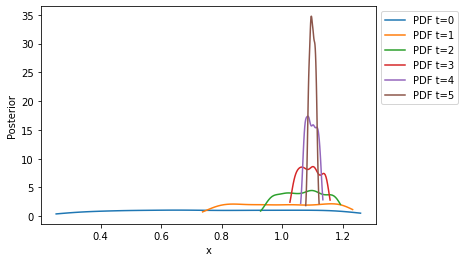

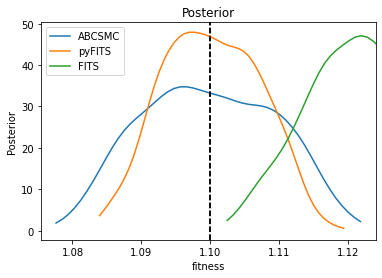

In [56]:
compare_fitness_inference(1.1)

Creating dataset...
running pyFits...
pyFITS run time  100.38
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.012179999999999816
Running FITS...


INFO:History:Start <ABCSMC(id=174, start_time=2021-02-11 09:01:32.636986, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  3.33
FITS max distance:  0.0140714
pyFITS max distance:  0.012179999999999816
Running SMC with epsilon:  0.012179999999999816


INFO:Epsilon:initial epsilon is 0.1297722
INFO:ABC:t: 0, eps: 0.1297722.
INFO:ABC:Acceptance rate: 1000 / 1995 = 5.0125e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.10772219999999999.
INFO:ABC:Acceptance rate: 1000 / 2063 = 4.8473e-01, ESS=9.8226e+02.
INFO:ABC:t: 2, eps: 0.06864483240208903.
INFO:ABC:Acceptance rate: 1000 / 2058 = 4.8591e-01, ESS=9.9863e+02.
INFO:ABC:t: 3, eps: 0.03684868059135879.
INFO:ABC:Acceptance rate: 1000 / 2005 = 4.9875e-01, ESS=9.9395e+02.
INFO:ABC:t: 4, eps: 0.01900773155707282.
INFO:ABC:Acceptance rate: 1000 / 2054 = 4.8685e-01, ESS=9.9625e+02.
INFO:ABC:t: 5, eps: 0.00950807628240467.
INFO:ABC:Acceptance rate: 1000 / 1979 = 5.0531e-01, ESS=9.9950e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=174, start_time=2021-02-11 09:01:32.636986, end_time=2021-02-11 09:01:59.964338)>


SMC run time:  27.35
Total number of SMC simulations:  13154


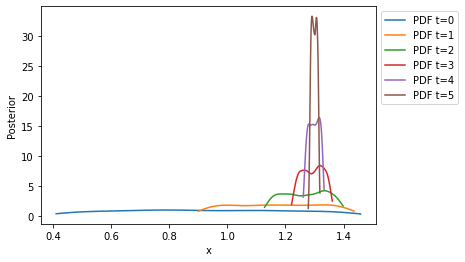

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='fitness', ylabel='Posterior'>)

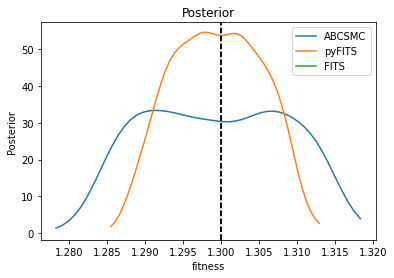

In [83]:
compare_fitness_inference(1.3)

## Comparing between FITS and SMC with fitness = 1

Creating dataset...
running pyFits...
pyFITS run time  97.18
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.030284800000000233
Running FITS...


INFO:History:Start <ABCSMC(id=173, start_time=2021-02-11 08:59:12.676093, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  11.32
FITS max distance:  0.0232673
pyFITS max distance:  0.030284800000000233
Running SMC with epsilon:  0.030284800000000233


INFO:Epsilon:initial epsilon is 0.26499419999999996
INFO:ABC:t: 0, eps: 0.26499419999999996.
INFO:ABC:Acceptance rate: 1000 / 1963 = 5.0942e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.23650919999999992.
INFO:ABC:Acceptance rate: 1000 / 2117 = 4.7237e-01, ESS=9.7948e+02.
INFO:ABC:t: 2, eps: 0.1582709577482402.
INFO:ABC:Acceptance rate: 1000 / 2011 = 4.9727e-01, ESS=9.9753e+02.
INFO:ABC:t: 3, eps: 0.09041727089140175.
INFO:ABC:Acceptance rate: 1000 / 1962 = 5.0968e-01, ESS=9.9854e+02.
INFO:ABC:t: 4, eps: 0.04574280758217456.
INFO:ABC:Acceptance rate: 1000 / 2046 = 4.8876e-01, ESS=9.9862e+02.
INFO:ABC:t: 5, eps: 0.022913020655174185.
INFO:ABC:Acceptance rate: 1000 / 2012 = 4.9702e-01, ESS=9.9916e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=173, start_time=2021-02-11 08:59:12.676093, end_time=2021-02-11 08:59:46.090125)>


SMC run time:  33.45
Total number of SMC simulations:  13111


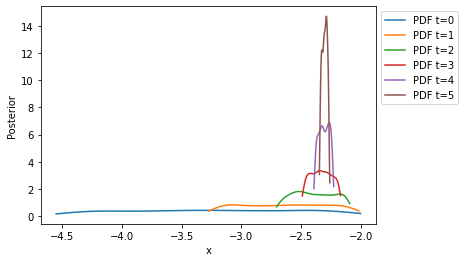

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

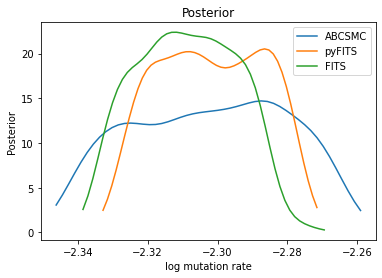

In [82]:
compare_pyFITS(0.005, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  100.22
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0012148000000000363
Running FITS...


INFO:History:Start <ABCSMC(id=175, start_time=2021-02-11 09:03:52.481803, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  10.17
FITS max distance:  0.00111967
pyFITS max distance:  0.0012148000000000363
Running SMC with epsilon:  0.0012148000000000363


INFO:Epsilon:initial epsilon is 0.0055074
INFO:ABC:t: 0, eps: 0.0055074.
INFO:ABC:Acceptance rate: 1000 / 1922 = 5.2029e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.004967399999999999.
INFO:ABC:Acceptance rate: 1000 / 2113 = 4.7326e-01, ESS=9.6396e+02.
INFO:ABC:t: 2, eps: 0.0032674.
INFO:ABC:Acceptance rate: 1000 / 2053 = 4.8709e-01, ESS=9.9355e+02.
INFO:ABC:t: 3, eps: 0.0017447584722002014.
INFO:ABC:Acceptance rate: 1000 / 2059 = 4.8567e-01, ESS=9.9566e+02.
INFO:ABC:t: 4, eps: 0.0009717141099060753.
INFO:ABC:Acceptance rate: 1000 / 1953 = 5.1203e-01, ESS=9.9618e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=175, start_time=2021-02-11 09:03:52.481803, end_time=2021-02-11 09:04:16.453128)>


SMC run time:  24.0
Total number of SMC simulations:  11100


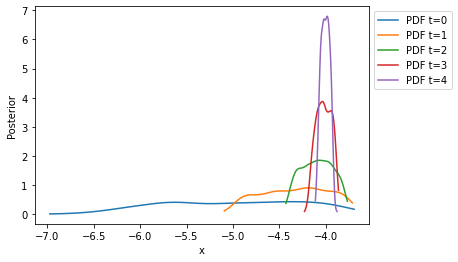

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

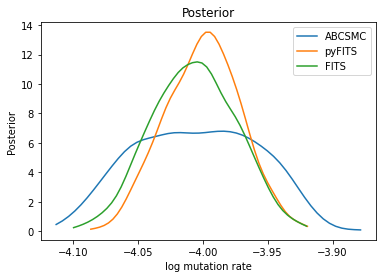

In [84]:
compare_pyFITS(0.0001, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  94.36
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0005752000000000545
Running FITS...


INFO:History:Start <ABCSMC(id=176, start_time=2021-02-11 09:06:02.633582, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  9.78
FITS max distance:  0.000525173
pyFITS max distance:  0.0005752000000000545
Running SMC with epsilon:  0.0005752000000000545


INFO:Epsilon:initial epsilon is 0.0016588
INFO:ABC:t: 0, eps: 0.0016588.
INFO:ABC:Acceptance rate: 1000 / 2010 = 4.9751e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.0014749999999999971.
INFO:ABC:Acceptance rate: 1000 / 2091 = 4.7824e-01, ESS=9.8639e+02.
INFO:ABC:t: 2, eps: 0.0010304771033298483.
INFO:ABC:Acceptance rate: 1000 / 1916 = 5.2192e-01, ESS=9.8807e+02.
INFO:ABC:t: 3, eps: 0.0005766374182807896.
INFO:ABC:Acceptance rate: 1000 / 2119 = 4.7192e-01, ESS=9.9606e+02.
INFO:ABC:t: 4, eps: 0.00039880000000000015.
INFO:ABC:Acceptance rate: 1000 / 2110 = 4.7393e-01, ESS=9.9244e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=176, start_time=2021-02-11 09:06:02.633582, end_time=2021-02-11 09:06:25.949290)>


SMC run time:  23.34
Total number of SMC simulations:  11246


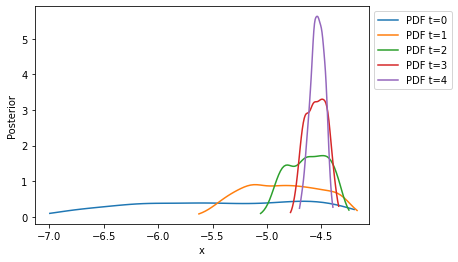

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

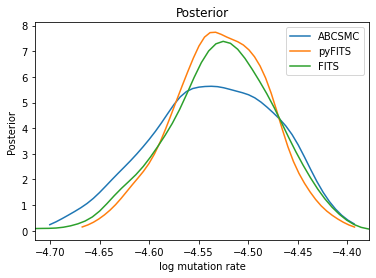

In [85]:
compare_pyFITS(0.00003, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  95.15
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.00011000000000013825
Running FITS...


INFO:History:Start <ABCSMC(id=183, start_time=2021-02-11 09:22:37.029248, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  9.22
FITS max distance:  0.0001024
pyFITS max distance:  0.00011000000000013825
Running SMC with epsilon:  0.00011000000000013825


INFO:Epsilon:initial epsilon is 0.0012115999999999891
INFO:ABC:t: 0, eps: 0.0012115999999999891.
INFO:ABC:Acceptance rate: 1000 / 2104 = 4.7529e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.00010340000000000009.
INFO:ABC:Acceptance rate: 1000 / 1683 = 5.9418e-01, ESS=9.8499e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=183, start_time=2021-02-11 09:22:37.029248, end_time=2021-02-11 09:22:44.285505)>


SMC run time:  7.28
Total number of SMC simulations:  4787


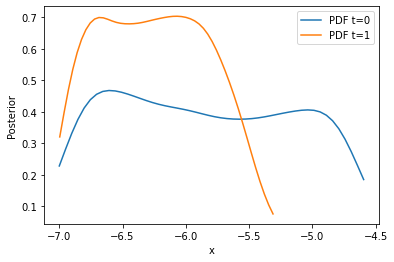

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

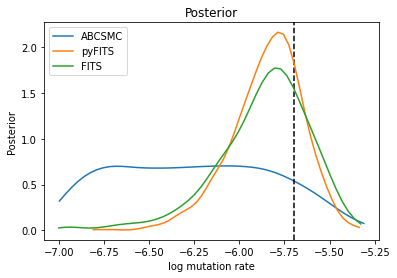

In [110]:
compare_pyFITS(0.000002, [-7,-2], 100000, 0.01)

Creating dataset...
running pyFits...
pyFITS run time  87.54
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 3.3599999999927985e-05
Running FITS...


INFO:History:Start <ABCSMC(id=182, start_time=2021-02-11 09:20:38.290392, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  9.4
FITS max distance:  3.3600000000000004e-05
pyFITS max distance:  3.3599999999927985e-05
Running SMC with epsilon:  3.3599999999927985e-05


INFO:Epsilon:initial epsilon is 0.0017431999999999853
INFO:ABC:t: 0, eps: 0.0017431999999999853.
INFO:ABC:Acceptance rate: 1000 / 1989 = 5.0277e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 9.119999999999942e-05.
INFO:ABC:Acceptance rate: 1000 / 2150 = 4.6512e-01, ESS=9.7907e+02.
INFO:ABC:t: 2, eps: 3.16e-05.
INFO:ABC:Acceptance rate: 1000 / 2044 = 4.8924e-01, ESS=9.8073e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=182, start_time=2021-02-11 09:20:38.290392, end_time=2021-02-11 09:20:51.326112)>


SMC run time:  13.06
Total number of SMC simulations:  7183


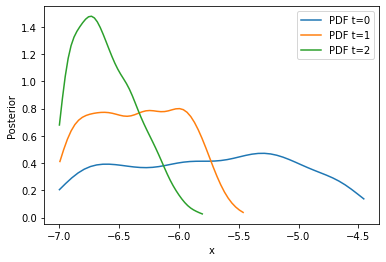

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

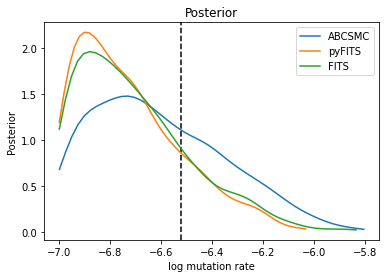

In [109]:
compare_pyFITS(0.0000003, [-7,-2], 100000, 0.01)

## And with fitness = 1.01

### Choosing reasonable values:

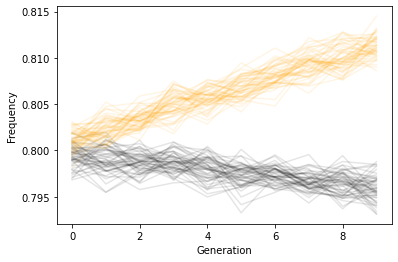

In [88]:
pop_size = 100000000
gen_num = 10
fitness = 1
mutation_rate = 0.0007
sample_size = 100000
intial_freq = 0.8
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='black').mean()
fitness = 1.01
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='orange').mean()


Creating dataset...
running pyFits...
pyFITS run time  90.43
pyFITS Created posterior from 1000 results
pyFITS max epsilon: 0.0050400000000001876
Running FITS...


INFO:History:Start <ABCSMC(id=179, start_time=2021-02-11 09:11:56.306595, end_time=None)>
INFO:ABC:Calibration sample before t=0.


FITS run time:  10.6
FITS max distance:  0.00438419
pyFITS max distance:  0.0050400000000001876
Running SMC with epsilon:  0.0050400000000001876


INFO:Epsilon:initial epsilon is 0.0397956
INFO:ABC:t: 0, eps: 0.0397956.
INFO:ABC:Acceptance rate: 1000 / 1954 = 5.1177e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.035400599999999977.
INFO:ABC:Acceptance rate: 1000 / 2233 = 4.4783e-01, ESS=9.8973e+02.
INFO:ABC:t: 2, eps: 0.02532608236392018.
INFO:ABC:Acceptance rate: 1000 / 2015 = 4.9628e-01, ESS=9.9713e+02.
INFO:ABC:t: 3, eps: 0.013975395826053739.
INFO:ABC:Acceptance rate: 1000 / 2062 = 4.8497e-01, ESS=9.9933e+02.
INFO:ABC:t: 4, eps: 0.007316762636962784.
INFO:ABC:Acceptance rate: 1000 / 2034 = 4.9164e-01, ESS=9.9945e+02.
INFO:ABC:t: 5, eps: 0.0036562700937874124.
INFO:ABC:Acceptance rate: 1000 / 1949 = 5.1308e-01, ESS=9.9994e+02.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=179, start_time=2021-02-11 09:11:56.306595, end_time=2021-02-11 09:12:23.666904)>


SMC run time:  27.39
Total number of SMC simulations:  13247


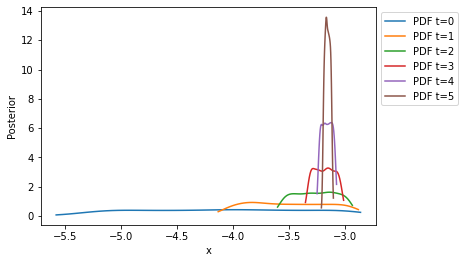

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior'}, xlabel='log mutation rate', ylabel='Posterior'>)

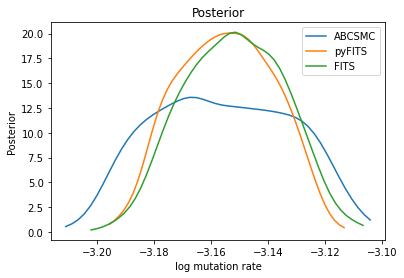

In [89]:
compare_pyFITS(0.0007, params_file='../FITS/params_fit.txt', fitness=1.01)

In [ ]:
THE END!